In [90]:
# !pip install ucimlrepo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from copy import deepcopy
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor

In [91]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
df = pd.read_excel(url, skiprows=1, header=None)
column_names = [
    'Cement', 'BlastFurnaceSlag', 'FlyAsh', 'Water', 'Superplasticizer',
    'CoarseAggregate', 'FineAggregate', 'Age', 'ConcreteCompressiveStrength'
]
df.columns = column_names
X = df.drop('ConcreteCompressiveStrength', axis=1).astype(float)
y = df['ConcreteCompressiveStrength'].astype(float)
print(X.shape, y.shape)
print(X.dtypes)


(1030, 8) (1030,)
Cement              float64
BlastFurnaceSlag    float64
FlyAsh              float64
Water               float64
Superplasticizer    float64
CoarseAggregate     float64
FineAggregate       float64
Age                 float64
dtype: object


In [92]:
if X.duplicated().sum() > 0:
    print(f"Removing {X.duplicated().sum()} duplicate rows")
    X = X.drop_duplicates()
    y = y[X.index]

missing_values = X.isna().sum().sum()
if missing_values > 0:
    print(f"Missing values found: {missing_values}")
    if missing_values <= 0.05 * len(X):
        X = X.fillna(X.median())
        print("Missing values imputed using median.")
    else:
        valid_idx = X.dropna().index
        X, y = X.loc[valid_idx], y.loc[valid_idx]
        print("Dropped rows with missing values.")
else:
    print("No missing values found.")

print(f"After preprocessing: {X.shape}\n")


Removing 34 duplicate rows
No missing values found.
After preprocessing: (996, 8)



In [93]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
val_fraction = 0.15 / 0.85
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_fraction, random_state=42
)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

Train: (696, 8) Validation: (150, 8) Test: (150, 8)


In [94]:
class AdaBoostScratch:
  def __init__ (self, M=50, baseEstimator=None, random_state=None) :
    self.M = M
    self.baseEstimator = baseEstimator if baseEstimator is not None else DecisionTreeRegressor(max_depth=1)
    self.learners = []
    self.random_state = random_state
    self.alphas = []

  def fit(self, X, y):
    m = X.shape[0]
    w = np.ones(m) / m
    self.learners = []
    self.alphas = []

    for _ in range(self.M):
      learner = deepcopy(self.baseEstimator)
      learner.fit(X, y, sample_weight=w)
      y_pred = learner.predict(X)
      errors = np.abs(y - y_pred)
      max_error = errors.max()
      if max_error == 0:
        self.learners.append(learner)
        self.alphas.append(1E9)
        break
      normalized_errors = errors/max_error
      e_m = np.dot(w, normalized_errors) / w.sum()
      if e_m >= 0.5:
          break

      beta_m = e_m / (1-e_m)
      alpha_m = np.log(1.0/beta_m)

      w = w * (beta_m ** (1 - normalized_errors))
      w = w / w.sum()

      self.learners.append(learner)
      self.alphas.append(alpha_m)
    return self

  def predict(self, X):
    preds = np.vstack([learner.predict(X) for learner in self.learners])
    alphas = np.array(self.alphas)[:, None]
    return (alphas * preds).sum(axis=0) / alphas.sum()


Validation R2:  0.3704225411625468
Validation R2:  0.418057418233878
Validation R2:  0.4254800077901676
Validation R2:  0.4343418323871675
Validation R2:  0.44733426160542533
Validation R2:  0.4682293597762188
Validation R2:  0.4682926700804968
Validation R2:  0.46829267024791255
Validation R2:  0.46829267024791255
Validation R2:  0.46829267024791255
Validation R2:  0.46829267024791255
Validation R2:  0.46829267024791255
Validation R2:  0.46829267024791255


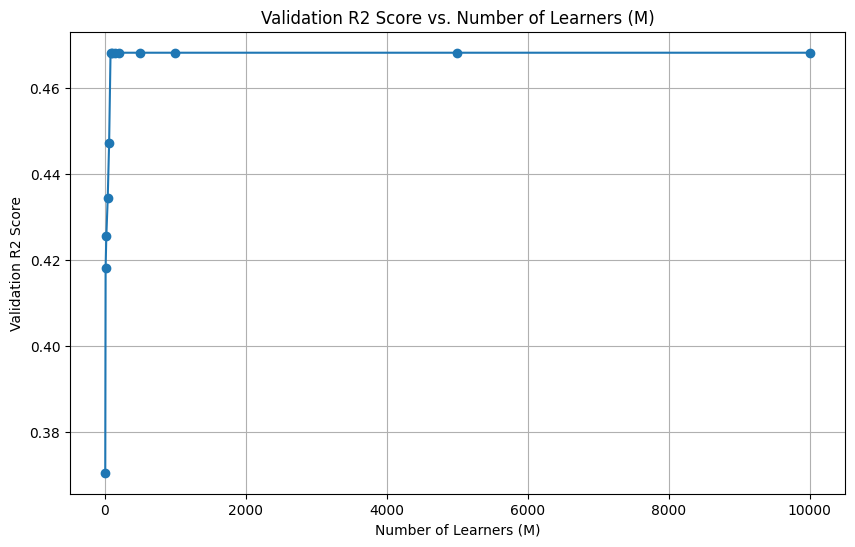

Best M:  150 with R2 score:  0.46829267024791255


In [95]:
MList = [5, 10, 20, 40, 60, 80, 100, 150, 200, 500, 1000, 5000, 10000]
val_scores = []

for M in MList:
  model = AdaBoostScratch(M=M, baseEstimator=DecisionTreeRegressor(max_depth=1, random_state=42))
  model.fit(X_train, y_train)
  y_val_pred = model.predict(X_val)
  r2 = r2_score(y_val, y_val_pred)
  print('Validation R2: ', r2)
  val_scores.append(r2)

plt.figure(figsize=(10, 6))
plt.plot(MList, val_scores, marker='o')
plt.xlabel('Number of Learners (M)')
plt.ylabel('Validation R2 Score')
plt.title('Validation R2 Score vs. Number of Learners (M)')
plt.grid(True)
plt.show()

best_idx = np.argmax(val_scores)
best_M = MList[best_idx]
print('Best M: ', best_M, 'with R2 score: ', val_scores[best_idx])


Test R2:  0.42840772240393543


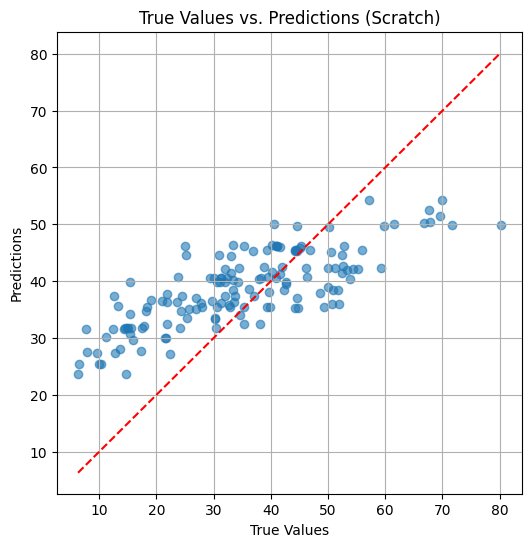

In [96]:
best_model = AdaBoostScratch(M=best_M, baseEstimator=DecisionTreeRegressor(max_depth=1, random_state=42))
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print('Test R2: ', r2_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions (Scratch)')
plt.grid(True)
plt.show()

Test R2 by Scikit:  0.4336293300146248


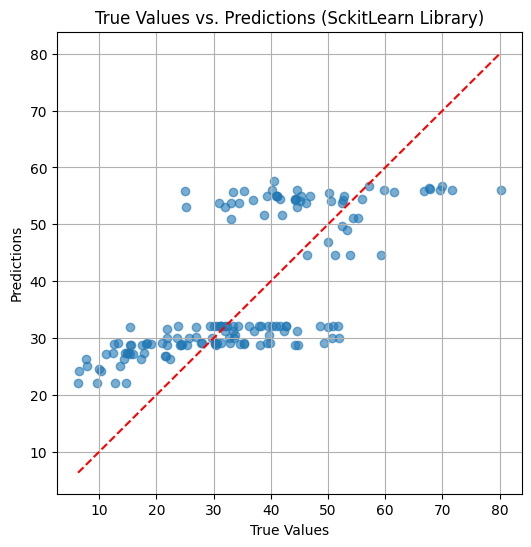

In [97]:
skModel = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=1),
    n_estimators=best_M,
    random_state=42
)
skModel.fit(X_train, y_train)
y_test_pred_sk = skModel.predict(X_test)
r2_test_sk = r2_score(y_test, y_test_pred_sk)
print('Test R2 by Scikit: ', r2_test_sk)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_test_pred_sk, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs. Predictions (SckitLearn Library)')
plt.grid(True)
plt.show()

In [98]:
print('\nComparision:')
print('Scratch AdaBoost.R2 Test R^2:', r2_test)
print('Scikit AdaBoost.R2 Test R^2:', r2_test_sk)


Comparision:
Scratch AdaBoost.R2 Test R^2: 0.42840772240393543
Scikit AdaBoost.R2 Test R^2: 0.4336293300146248
